<h1>Lab : simplified JPEG encoder/decoder</h1>

# VERY IMPORTANT: Take time to read the guidance before coding.

**Read the guidance**

**Read the topic (.pdf file) first**

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Some useful functions:**
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

# **You can directly go to Section 3 and code there**

**Import the libs**

In [55]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io
import requests
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: Implementing this function is optional, as there is a relatively simple 'manual' method available for accomplishing the task (see the begining of Section 3)
# *   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.**





In [56]:

from collections import defaultdict
from typing import Dict, Any

def count_symbols(data: list) -> Dict[Any, int]:
    """
    Compute the frequency of each value in the list.
    """
    freq = defaultdict(int)
    for value in data:
        freq[value] += 1
    return dict(freq)


#testing
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [57]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))

    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]

        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [58]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)

    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [59]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing
sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)


Test 1
{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

(256, 256) RGB None 0 255


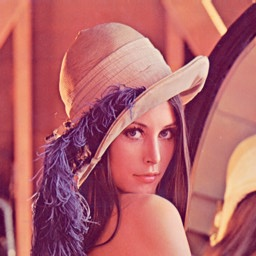

(256, 256) L None 17 225


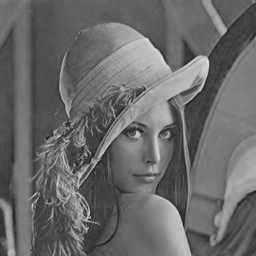

(256, 256) L None 0 235


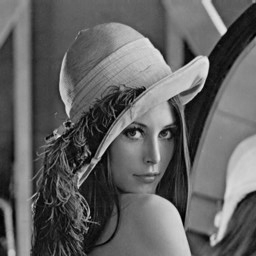

(256, 256) L None 48 255


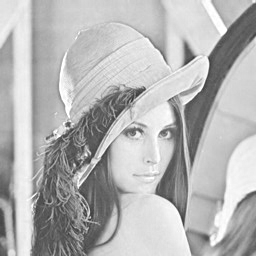

In [60]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
show(imgOriginal)

#TODO: show different channels
(B,G,R)=cv2.split(imgOriginal)
show(R)
show(G)
show(B)

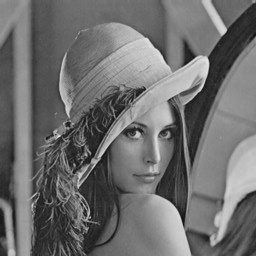

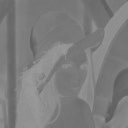

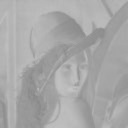

In [61]:
block_size = 8
image_ycrcb = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(image_ycrcb)
#sub sampling
Cr_subsampled = cv2.resize(Cr, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
Cb_subsampled = cv2.resize(Cb, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
imshow(Y)
imshow(Cr_subsampled)
imshow(Cb_subsampled)

In [62]:

def split_into_blocks(array):
    # Get the dimensions of the input array
    height, width = array.shape
    negative = np.full((8, 8), -128)

    # Define the block size
    block_size = 8

    # Calculate the number of blocks in each dimension
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Initialize an empty list to store the blocks
    blocks = []

    # Iterate over the image to extract blocks
    for line in range(num_blocks_y):
        for column in range(num_blocks_x):
            # Create an empty block
            block = np.zeros((block_size, block_size))
            for i in range(block_size):
                for j in range(block_size):
                    # Check if pixel index is within image bounds
                    if line + i < height and column + j < width:
                        # Centering pixel values by subtracting 128
                        block[i][j] = array[line + i][column + j]
            # Append block to img_block list
            block = block + negative
            blocks.append(block)

    return blocks

def apply_DCT(split_channel):
  imgDCT=[]
  for i in range(len(split_channel)):
    imgDCT.append(cv2.dct(split_channel[i]))
  return imgDCT

def apply_quantization_table(arrays, quantization_table):
    # Initialize an empty list to store the quantized arrays
    quantized_arrays = []

    # Iterate over each array in the list
    for array in arrays:
        # Perform element-wise multiplication with the quantization table
        quantized_array = np.round(array / quantization_table)

        # Append the quantized array to the list
        quantized_arrays.append(quantized_array)

    return quantized_arrays



def apply_huffman_to_list(arrays):
    # Initialize an empty list to store the results
    huffman_encoded_arrays = []
    table_list=[]
    # Iterate over each array in the list
    for array in arrays:
        # Apply Huffman encoding to the current array
        table = construct_huffman_table(array)
        huffman_encoded_array = encode_huffman(array,table)

        # Append the result to the list
        table_list.append(table)
        huffman_encoded_arrays.append(huffman_encoded_array)

    return huffman_encoded_arrays,table_list


def apply_f_to_list(lst, f1):
    return [f1(item) for item in lst]
def inverse_quantization(quantized_array, quantization_table):
    return quantized_array * quantization_table
import numpy as np

def blocks_to_2d_array(blocks):

    rows = 256  # Number of rows in the final 2D array
    cols = 256  # Number of columns in the final 2D array

    result = []
    for i in range(rows):
        row = []
        for j in range(cols):
            # Extracting elements from each block and flattening the blocks
            row.extend(blocks[i*8 + k][j] for k in range(8))
        result.append(row)

    return result

def inverse_quantization(arrays,quantization_table):
      # Initialize an empty list to store the quantized arrays
    quantized_arrays = []

    # Iterate over each array in the list
    for array in arrays:
        # Perform element-wise multiplication with the quantization table
        quantized_array = np.round(array * quantization_table)

        # Append the quantized array to the list
        quantized_arrays.append(quantized_array)

    return quantized_arrays

In [63]:
def zigzag_indexs(size:int) -> np.ndarray:
    '''
    Construct the zigag indexs of a `(size, size)` square matrix .
    Return
        shape = (size*size, 2)
    '''
    out = np.zeros((size*size, 2), dtype=np.int32)

    # Initialize the starting position
    row, col = 0, 0

    # Loop through the array and fill in the zigzag pattern
    for i in range(size * size):
        out[i] = (row, col)

        # Check if we need to change direction
        if (row + col) % 2 == 0:
            if col == size - 1: #On va en bas
                row+=1
            elif row == 0: #On va à droite
                col+=1
            else: #On va en haut à droite
                row-=1
                col+=1
        else:
            if row == size - 1:  #On va à droite
                col+=1
            elif col == 0: #On va en bas
                row+=1
            else: #On va en bas à gauche
                row+=1
                col-=1

    return out

def encode_zigzag(arr: np.ndarray) -> np.ndarray:
    '''
    Encode a 2D array using zigzag pattern.
    Input array must be a square matrix of size `(size,size)`
    Return a 1D array of length `(size*size)`
    '''
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    N, M = arr.shape[:2]
    assert N == M, "arr[:2] must be a square matrix"

    #TODO
    # out = np.zeros(N*M, dtype=arr.dtype)
    # zig_i = zigzag_indexs(M)
    # for i in range(M*N):
    #
    index_N, index_M = np.transpose(zigzag_indexs(M))
    return arr[index_N, index_M]

def decode_zigzag(arr: np.ndarray) -> np.ndarray:
    '''
    Decode a 1D array of length `(size*size)` using zigzag pattern.
    Return a 2D array of size `(size,size)`
    '''
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    total = arr.shape[0]
    size = int(len(arr) ** 0.5)
    assert total == size * size, f"array is not a perfect square {size*size} != {total}"

    #TODO
    out = np.zeros((size, size), dtype=arr.dtype)

    index_N, index_M = np.transpose(zigzag_indexs(size))

    for i in range(size * size):
        out[index_N[i], index_M[i]] = arr[i]

    return out
def encode_rle(data: list, symbol: int = 0, escape: int = 257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered,
    the next value is `escape` followed by the number of `symbol`.
    '''
    out = []
    count = 0
    for i in data:
        if i == symbol:
            count += 1
        else:
            # flush the count
            if count > 0:
                out.append(escape)
                out.append(count)
                count = 0
            out.append(i)
    # further flush the count if any left
    if count > 0:
        out.append(escape)
        out.append(count)
    return np.array(out)

def decode_rle(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Decode a list of values using run length encoding of caracter `symbol`
    '''
    #TODO
    data_decode_rle = []
    i = 0
    while i < len(data):
        if data[i] == escape:
            for j in range(int(data[i+1])):
                data_decode_rle.append(symbol)
            i+=2
        else:
            data_decode_rle.append(data[i])
            i+=1

    return np.array(data_decode_rle)


In [64]:

Y_split=split_into_blocks(Y)
Cr_split=split_into_blocks(Cr_subsampled)
Cb_split=split_into_blocks(Cb_subsampled)

In [65]:

Y_DCT=apply_DCT(Y_split)
Cr_DCT=apply_DCT(Cr_split)
Cb_DCT=apply_DCT(Cb_split)

Text(0.5, 1.0, 'An 8x8 DCT block')

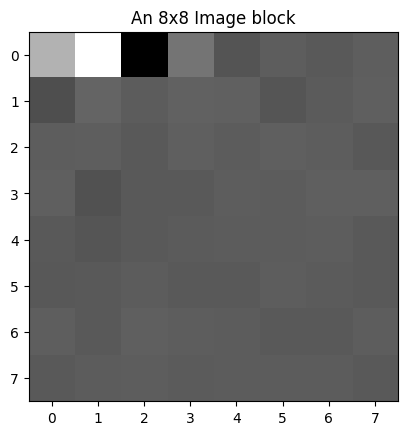

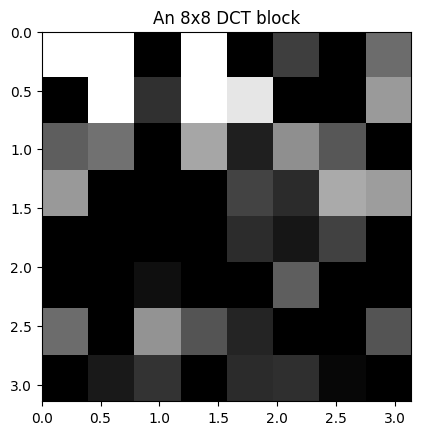

In [66]:
pos = 128
# Extract a block from image
plt.figure()
plt.imshow(Y_DCT[598],cmap='gray')
plt.title( "An 8x8 Image block")
# Extract a block from image
plt.figure()
plt.imshow(Y_DCT[598],cmap='gray',vmax= np.max(Y_DCT)*0.01,vmin = 0, extent=[0,np.pi,np.pi,0])
plt.title( "An 8x8 DCT block")

In [67]:
Y_quant=apply_quantization_table(Y_DCT,qY)
Cr_quant=apply_quantization_table(Cr_DCT,qC)
Cb_quant=apply_quantization_table(Cb_DCT,qC)

In [68]:
Y_zigzag=apply_f_to_list(Y_quant,encode_zigzag)
Cr_zigzag=apply_f_to_list(Cr_quant,encode_zigzag)
Cb_zigzag=apply_f_to_list(Cb_quant,encode_zigzag)

In [69]:
Y_rlencode=apply_f_to_list(Y_zigzag,encode_rle)
Cr_rlencode=apply_f_to_list(Cr_zigzag,encode_rle)
Cb_rlencode=apply_f_to_list(Cb_zigzag,encode_rle)

In [70]:
Y_rlencode=[encode_rle(array) for array in Y_zigzag]
#print(Y_rlencode[0])
encoded_data = encode_rle([0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2])
print(encoded_data)


[257   2   1   1   1 257   3   2   2   2   2   2]


In [71]:
Y_huffman,Y_huffman_table = apply_huffman_to_list(Y_rlencode)
Cr_huffman,Cr_huffman_table = apply_huffman_to_list(Cr_rlencode)
Cb_huffman,Cb_huffman_table = apply_huffman_to_list(Cb_rlencode)

In [72]:
#DECODING huffman
Y_encoded=[decode_huffman(Y_huffman_item, Y_huffman_table_item) for Y_huffman_item, Y_huffman_table_item in zip(Y_huffman, Y_huffman_table)]
Cr_encoded=[decode_huffman(Cr_huffman_item, Cr_huffman_table_item) for Cr_huffman_item, Cr_huffman_table_item in zip(Cr_huffman, Cr_huffman_table)]
Cb_encoded=[decode_huffman(Cb_huffman_item, Cb_huffman_table_item) for Cb_huffman_item, Cb_huffman_table_item in zip(Cb_huffman, Cb_huffman_table)]


In [73]:
#DECODING rle
Y_encoded = apply_f_to_list(Y_encoded,decode_rle)
Cr_encoded = apply_f_to_list(Cr_encoded,decode_rle)
Cb_encoded = apply_f_to_list(Cb_encoded,decode_rle)

In [74]:
#PATCHING

In [75]:
Y_encoded = apply_f_to_list(Y_encoded,decode_zigzag)
Cr_encoded = apply_f_to_list(Cr_encoded,decode_zigzag)
Cb_encoded = apply_f_to_list(Cb_encoded,decode_zigzag)

In [76]:
Y_encoded=inverse_quantization(Y_encoded,qY)
Y_encoded=np.array(Y_encoded)
print(Y_encoded[0])

[[ 80.  11. -10.   0.   0.   0.   0.   0.]
 [ 24.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


In [77]:
Y_encoded=inverse_quantization(Y_encoded,qY)
Cr_encoded=inverse_quantization(Cr_encoded,qC)
Cb_encoded=inverse_quantization(Cb_encoded,qC)

Y_encoded=np.array(Y_encoded)
Cr_encoded=np.array(Cr_encoded)
Cb_encoded=np.array(Cb_encoded)

for i in range(len(Y_encoded)):
  Y_encoded[i]=cv2.idct(Y_encoded[i])

for i in range(len(Cr_encoded)):
  Cr_encoded[i]=cv2.idct(Cr_encoded[i])
  Cb_encoded[i]=cv2.idct(Cb_encoded[i])

In [78]:
Cr_subsampled = cv2.resize(Cr, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)


In [79]:
Y_encoded=Y_encoded.reshape((256,256))
Cr_encoded=Cr_encoded.reshape((128,128))
Cb_encoded=Cb_encoded.reshape((128,128))

In [80]:

Cr_encoded=cv2.resize(Cr_encoded,None,fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
Cb_encoded=cv2.resize(Cb_encoded,None,fx=2, fy=2, interpolation=cv2.INTER_LINEAR)


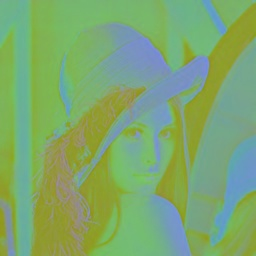

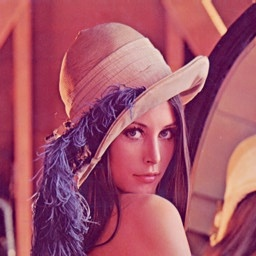

In [81]:
img = cv2.merge([Y,Cb,Cr])
imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
imshow(img)